### **Preprocessing Step**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Load Excel file
df = pd.read_excel("/content/AirQualityUCI.xlsx", engine='openpyxl')

In [4]:
#Remove empty columns
df.drop(columns=['Unnamed: 15', 'Unnamed: 16'], inplace=True, errors='ignore')

In [5]:
# Create datetime column as a timestamp index
df['Datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str),
                                 errors='coerce', dayfirst=True)
df.set_index('Datetime', inplace=True)


In [6]:
#Keep only the required inputs and outputs
df.drop(columns=['Date', 'Time'], inplace=True)


In [7]:
# Define input features and the target column
input_features = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)',
                  'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
target_column = 'C6H6(GT)'

In [8]:
# Keep only the required inputs and outputs
df = df[input_features + [target_column]].dropna()
#Normalize values between 0 and 1
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df),
                         columns=input_features + [target_column],
                         index=df.index)

In [9]:
#Print a sample of the processed data
print(df_scaled.head())

                     PT08.S1(CO)  PT08.S2(NMHC)  PT08.S3(NOx)  PT08.S4(NO2)  \
Datetime                                                                      
2004-10-03 18:00:00     0.696506       0.515949      0.435782      0.635966   
2004-10-03 19:00:00     0.666257       0.478355      0.476541      0.591176   
2004-10-03 20:00:00     0.715258       0.471935      0.464834      0.589748   
2004-10-03 21:00:00     0.703427       0.475663      0.448183      0.599580   
2004-10-03 22:00:00     0.657328       0.428956      0.487382      0.568067   

                     PT08.S5(O3)         T        RH        AH  C6H6(GT)  
Datetime                                                                  
2004-10-03 18:00:00     0.538977  0.873262  0.861979  0.992715  0.803369  
2004-10-03 19:00:00     0.430539  0.872036  0.857910  0.992555  0.793949  
2004-10-03 20:00:00     0.467909  0.866312  0.879643  0.992678  0.792434  
2004-10-03 21:00:00     0.515380  0.862633  0.900511  0.992858  0.79331

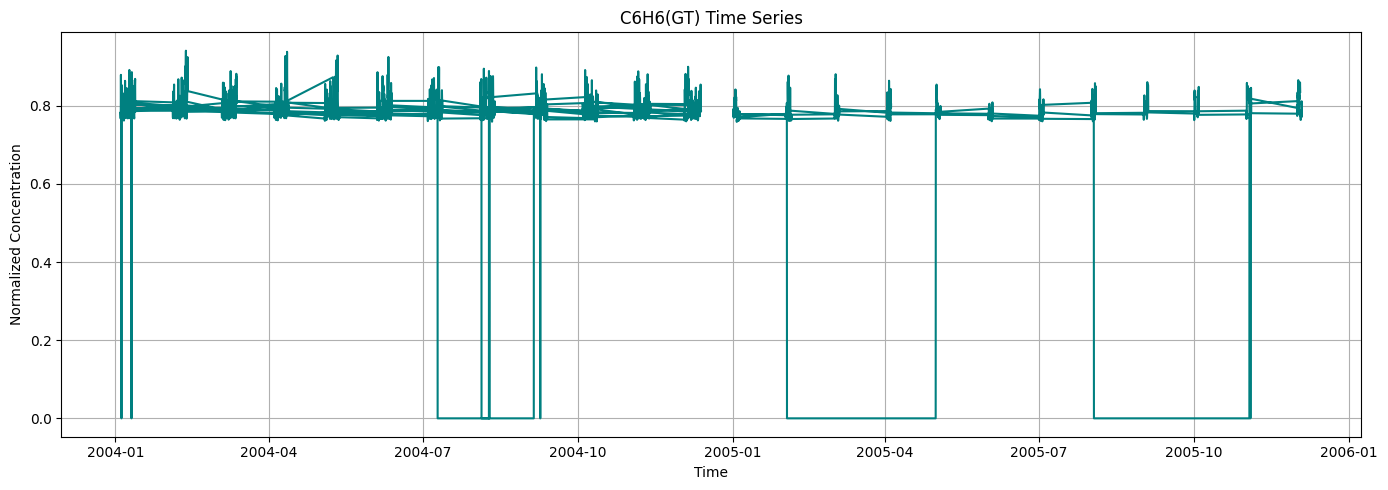

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

#===== 1. Time series plot of C6H6 concentration (Target) =====
plt.figure(figsize=(14, 5))
plt.plot(df_scaled.index, df_scaled['C6H6(GT)'], color='teal')
plt.title('C6H6(GT) Time Series')
plt.xlabel('Time')
plt.ylabel('Normalized Concentration')
plt.grid(True)
plt.tight_layout()
plt.show()

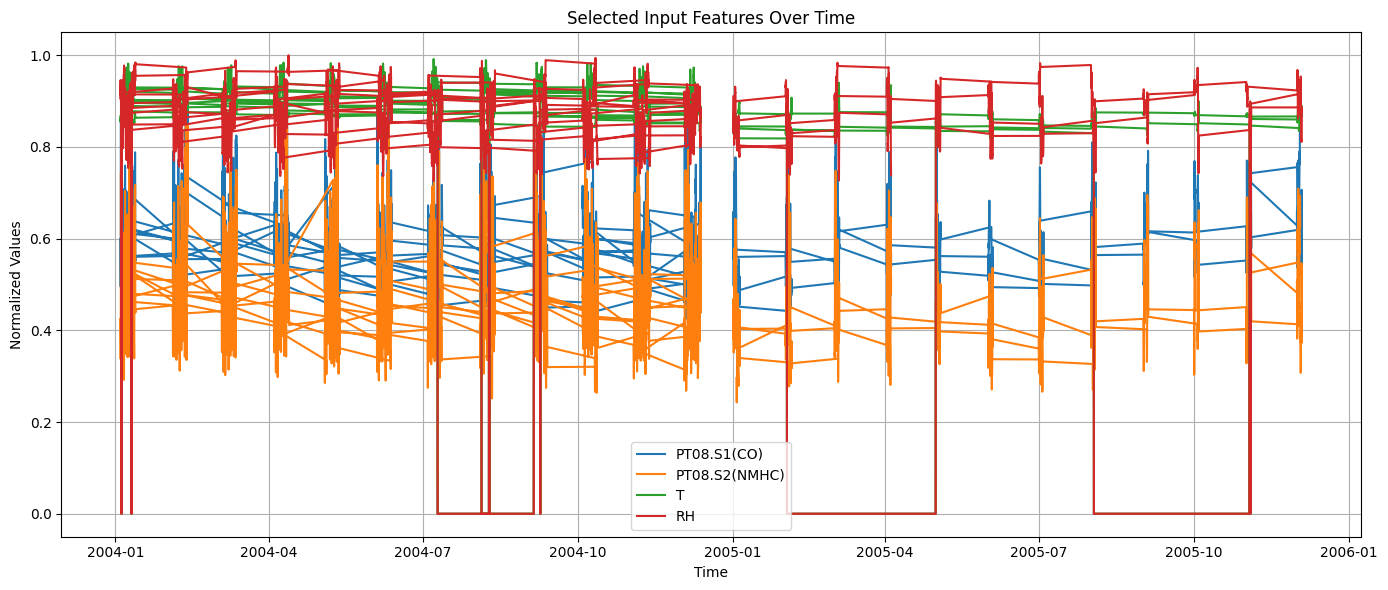

In [11]:
#===== 2. Time series plot of some Inputs =====
plt.figure(figsize=(14, 6))
for col in ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'T', 'RH']:
    plt.plot(df_scaled.index, df_scaled[col], label=col)
plt.title('Selected Input Features Over Time')
plt.xlabel('Time')
plt.ylabel('Normalized Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

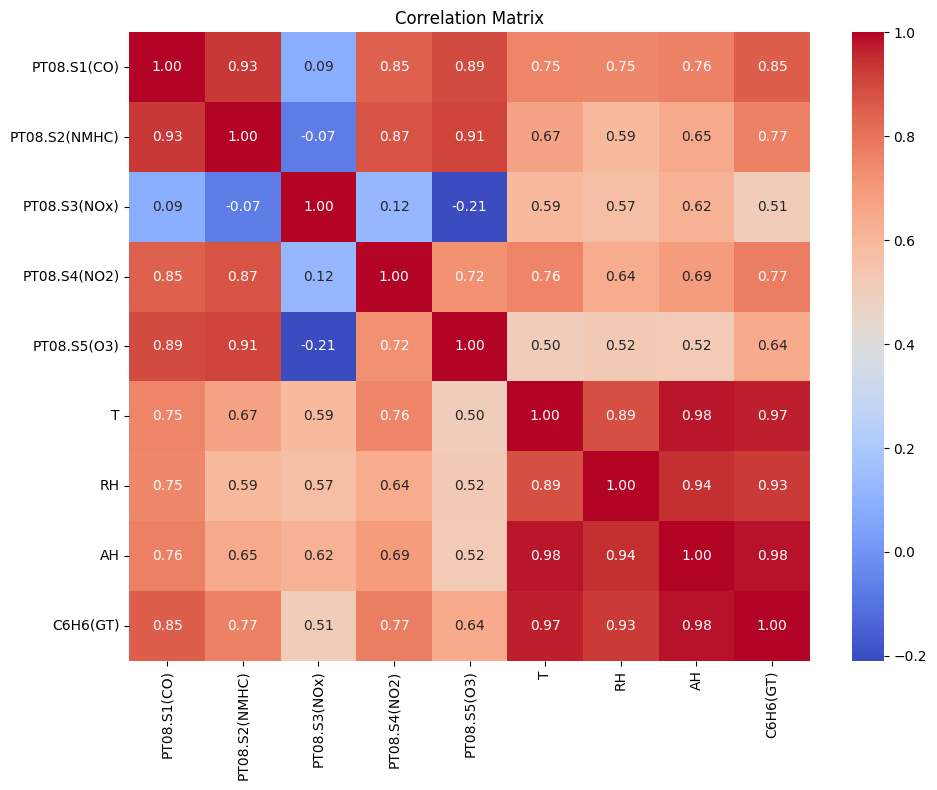

In [12]:
#===== 3. Correlation matrix (Heatmap) =====
plt.figure(figsize=(10, 8))
corr_matrix = df_scaled.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

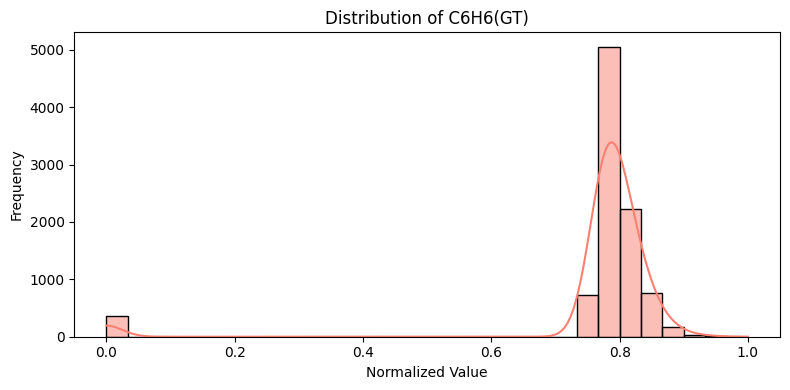

In [13]:
#===== 4. Distribution plot for C6H6 (GT) =====
plt.figure(figsize=(8, 4))
sns.histplot(df_scaled['C6H6(GT)'], bins=30, kde=True, color='salmon')
plt.title('Distribution of C6H6(GT)')
plt.xlabel('Normalized Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [14]:
#Prepare the data sequence
#Number of time steps used

TIME_STEPS = 24

#Convert the data to sequences
def create_sequences(data, target_col_index, time_steps=TIME_STEPS):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps, :-1])  # جميع الأعمدة ما عدا الـ target
        y.append(data[i+time_steps, target_col_index])  # الهدف في المستقبل
    return np.array(X), np.array(y)

#Convert DataFrame to NumPy array
data_array = df_scaled.values
target_index = df_scaled.columns.get_loc("C6H6(GT)")

X, y = create_sequences(data_array, target_index, TIME_STEPS)

#Final shape of the data
print("X shape:", X.shape)  # (samples, time_steps, features)
print("y shape:", y.shape)  # (samples,)

X shape: (9333, 24, 8)
y shape: (9333,)


In [15]:
# تقسيم البيانات إلى تدريب، تحقق، واختبار بنسبة 70%، 15%، 15%
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
test_size = len(X) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

print("Training samples :", X_train.shape[0])
print("Validation samples:", X_val.shape[0])
print("Testing samples   :", X_test.shape[0])


Training samples : 6533
Validation samples: 1399
Testing samples   : 1401


### **LSTM Model**

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

#Model building
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,753 (73.25 KB)

 Trainable params: 18,753 (73.25 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
#Model training
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50, batch_size=32,
                    verbose=1)

Epoch 1/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0669 - val_loss: 0.0091
Epoch 2/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0039 - val_loss: 0.0072
Epoch 3/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0030 - val_loss: 0.0063
Epoch 4/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0027 - val_loss: 0.0057
Epoch 5/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0024 - val_loss: 0.0054
Epoch 6/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0027 - val_loss: 0.0050
Epoch 7/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0017 - val_loss: 0.0050
Epoch 8/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0021 - val_loss: 0.0045
Epoch 9/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0024 - val_loss: 0.0045
Epoch 10/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0018 - val_loss: 0.0044
Epoch 11/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0027 - val_loss: 0.0044
Epoch 12/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Prediction on validation data
y_val_pred = model.predict(X_val)

# Prediction on testing data
y_test_pred = model.predict(X_test)

# Validation evaluation
mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

# testing evaluation
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

#Print results
print(" Evaluation Metrics:")
print("\n Validation Set:")
print("MSE :", mse_val)
print("RMSE:", rmse_val)
print("MAE :", mae_val)
print("R² Score:", r2_val)

print("\n Testing Set:")
print("MSE :", mse_test)
print("RMSE:", rmse_test)
print("MAE :", mae_test)
print("R² Score:", r2_test)


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
 Evaluation Metrics:

 Validation Set:
MSE : 0.00445410813904173
RMSE: 0.06673910502128216
MAE : 0.022266954163736807
R² Score: 0.9226983333462638

 Testing Set:
MSE : 0.0019670990772106206
RMSE: 0.044351990679231304
MAE : 0.015349630160303425
R² Score: 0.9398807633981404


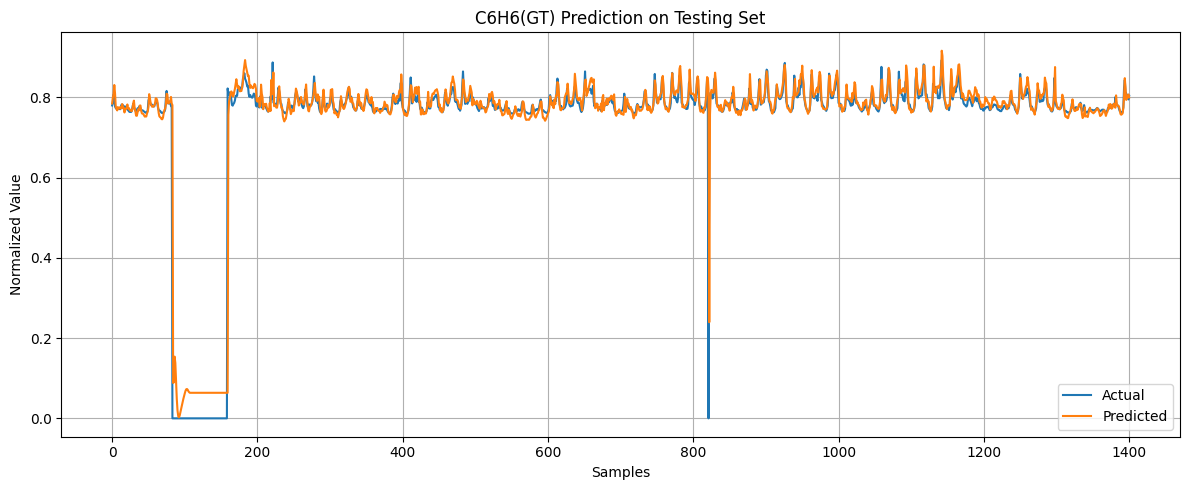

In [24]:
# Plotting actual versus predicted values ​​for testing data
plt.figure(figsize=(12, 5))
plt.plot(y_test, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.title('C6H6(GT) Prediction on Testing Set')
plt.xlabel('Samples')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

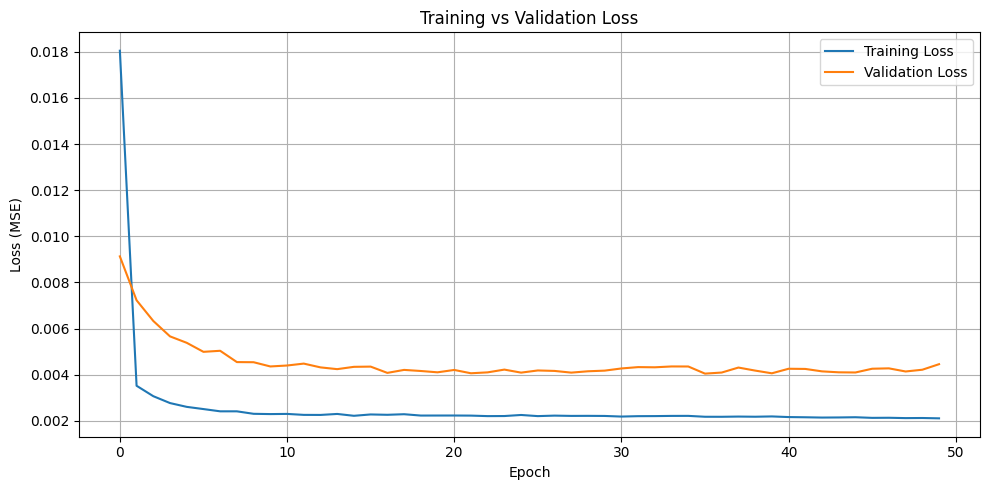

In [25]:
# Draw a loss curve
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
